In [103]:
import pandas as pd
import numpy as np
from smileFunctionalGroup import functional_group_exists #from smileFunctionalGroup.py created for this project
import rdkit
from rdkit import Chem

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
#Read the data
df_abs = pd.read_json('data.json')

In [75]:
df = df_abs.dropna() #drop items we could not get smiles codes for

In [76]:
df_transmittance = pd.read_json('data_transmittanceFiles.json')

In [77]:
#drop the yA to make the columns the same name, yA no longer needed as we can use just the y_n values the normalized absorbance values
dft = df_transmittance.drop(columns=['yA'])
#add the data frames together
df = pd.concat([df, dft], ignore_index=True)
#drop the columns we no longer need for classification
df = df.drop(columns = ['x','y','y_','jcamp'])
#look at df to ensure it seems right
df.head(3)

,x_,y_n,smiles
0,"[555.0, 558.7440273038, 562.4880546075, 566.23...","[0.0012570538, 0.0007674249, 2.556300000000000...",C1=CC=C(C=C1)OC2=CC=C(C=C2)Cl
1,"[555.0, 558.7440273038, 562.4880546075, 566.23...","[0.0194569516, 0.0025033769, 0.006071734200000...",CCCCC#CCCCCCCCl
2,"[555.0, 558.7440273038, 562.4880546075, 566.23...","[0.011878962600000001, 0.0045903729, 0.0022933...",CCCC(C)(CCC(C)C)O


In [78]:
df=df.dropna()

In [79]:
#add the carboxcylic acid label to each spectra
#1 = contains a carboxcylic acid 0 = does not contain a carboxcylic acid
df['carboxcylicAcid'] = [functional_group_exists(x, '[CX3](=O)[OX1H0-,OX2H1]') for x in df.smiles]

In [80]:
#build a dataframe with the wavenumbers as the columns and abs values as the elements
absorbances = df.y_n.to_list()
wavenumbers = df.x_[0]
df2 = pd.DataFrame(data=absorbances,columns=wavenumbers)
df2['smiles'] = df.smiles
#add the classifier
df2['carboxcylicAcid']=df.carboxcylicAcid

In [81]:
df2.head()

,555.0,558.7440273038,562.4880546075,566.2320819113,569.976109215,573.7201365188,577.4641638225,581.2081911263,584.95221843,588.6962457338,...,3819.7918088737,3823.5358361775,3827.2798634812,3831.023890785,3834.7679180887,3838.5119453925,3842.2559726962,3846.0,smiles,carboxcylicAcid
0,0.001257,0.000767,0.000026,0.000240,0.000730,0.001513,0.003204,0.004885,0.006861,0.008144,...,0.001268,0.001112,0.001182,0.001547,0.001781,0.001767,0.001656,0.001362,C1=CC=C(C=C1)OC2=CC=C(C=C2)Cl,0
1,0.019457,0.002503,0.006072,0.003486,0.003016,0.002266,0.001948,0.002633,0.003775,0.002967,...,0.006916,0.006142,0.005523,0.005652,0.006025,0.005974,0.005624,0.005624,CCCCC#CCCCCCCCl,0
2,0.011879,0.004590,0.002293,0.002298,0.003800,0.004275,0.004050,0.002804,0.001988,0.003156,...,0.004456,0.004973,0.005682,0.005357,0.004554,0.004387,0.004918,0.005012,CCCC(C)(CCC(C)C)O,0
3,0.002493,0.010488,0.017283,0.021403,0.022252,0.022538,0.021164,0.007701,0.002945,0.013754,...,0.002042,0.001595,0.002055,0.002125,0.003149,0.002391,0.002164,0.001410,COC(=O)OC,0
4,0.050332,0.042429,0.038806,0.029132,0.019194,0.027235,0.023681,0.019342,0.021757,0.023747,...,0.004904,0.005664,0.004724,0.003624,0.002766,0.002386,0.000901,0.000901,CCCCC(C)Br,0


In [82]:
df2.carboxcylicAcid.value_counts()

0    10874
1      776
Name: carboxcylicAcid, dtype: int64

In [83]:
#drop Nans
df2 = df2.dropna()

In [84]:
#look at number of spectra, after adding in transmittance spectra we go from about 8000 to about 12000 available spectra
len(df2)

11504

### Testing a SVM methond on a single label
Below we are testing the SVM model on predicting the carboxcylic acid functional group

In [85]:
# Split the data into training and testing sets
X = df2.drop(['carboxcylicAcid','smiles'],axis=1)  # Features
y = df2['carboxcylicAcid']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the classification model
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9656671012603216


### Adding more Labels

In [86]:
#define a dictionary of functional groups to add
functional_groups = {
    'alcohol': '[OH]',
    'alkane': '[CX4]',
    'alkene': '[CX3]=[CX3]',
    'alkyne': '[CX2]#[CX2]',
    'ether': '[OD2]([#6])[#6]',
    'ketone': '[CX3](=[OX1])[!#0]',
    'carbonyl': '[CX3](=[OX1])[#6]',
    'nitrile': '[NX1]#[CX2]',
    'amine': '[NX3;!$(NC=O)]',
    'aromatic': '[c]',
    'ester': '[CX3](=[OX1])[OX2H0][#6;!$(C=O)]',
    'aldehyde': '[CX3H1](=O)[#6]',
    'thiol': '[SH]'
}
#get a list of keys
kys = functional_groups.keys()


In [87]:
for key in kys:
    df2[key] = [functional_group_exists(x, functional_groups[key]) for x in df2.smiles]

In [88]:
df2.head()

,555.0,558.7440273038,562.4880546075,566.2320819113,569.976109215,573.7201365188,577.4641638225,581.2081911263,584.95221843,588.6962457338,...,alkyne,ether,ketone,carbonyl,nitrile,amine,aromatic,ester,aldehyde,thiol
0,0.001257,0.000767,0.000026,0.000240,0.000730,0.001513,0.003204,0.004885,0.006861,0.008144,...,0,1,0,0,0,0,1,0,0,0
1,0.019457,0.002503,0.006072,0.003486,0.003016,0.002266,0.001948,0.002633,0.003775,0.002967,...,1,0,0,0,0,0,0,0,0,0
2,0.011879,0.004590,0.002293,0.002298,0.003800,0.004275,0.004050,0.002804,0.001988,0.003156,...,0,0,0,0,0,0,0,0,0,0
3,0.002493,0.010488,0.017283,0.021403,0.022252,0.022538,0.021164,0.007701,0.002945,0.013754,...,0,1,1,0,0,0,0,1,0,0
4,0.050332,0.042429,0.038806,0.029132,0.019194,0.027235,0.023681,0.019342,0.021757,0.023747,...,0,0,0,0,0,0,0,0,0,0


In [167]:
for key in kys:    
    print(df2[key].value_counts())

0    8929
1    2575
Name: alcohol, dtype: int64
1    9251
0    2253
Name: alkane, dtype: int64
0    10082
1     1422
Name: alkene, dtype: int64
0    11270
1      234
Name: alkyne, dtype: int64
0    8784
1    2720
Name: ether, dtype: int64
0    7234
1    4270
Name: ketone, dtype: int64
0    7540
1    3964
Name: carbonyl, dtype: int64
0    11075
1      429
Name: nitrile, dtype: int64
0    9025
1    2479
Name: amine, dtype: int64
1    6558
0    4946
Name: aromatic, dtype: int64
0    10129
1     1375
Name: ester, dtype: int64
0    11277
1      227
Name: aldehyde, dtype: int64
0    11299
1      205
Name: thiol, dtype: int64


In [170]:
k = list(kys)
k.append('carboxcylicAcid')

In [91]:
df2[k]

,alcohol,alkane,alkene,alkyne,ether,ketone,carbonyl,nitrile,amine,aromatic,ester,aldehyde,thiol,carboxcylicAcid
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11645,0,1,0,0,0,1,1,0,0,1,0,0,0,0
11646,0,1,0,0,0,1,0,0,0,1,0,0,0,0
11647,0,1,0,0,0,1,1,0,0,1,0,0,0,0
11648,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [92]:
#defining a variable to drop everything except for the features in the df
drops = k.copy() #drop the labels by key
drops.append('smiles') #drop the smiles column
#look to verify the df looks correct
df2.drop(columns=drops)

,555.000000,558.744027,562.488055,566.232082,569.976109,573.720137,577.464164,581.208191,584.952218,588.696246,...,3812.303754,3816.047782,3819.791809,3823.535836,3827.279863,3831.023891,3834.767918,3838.511945,3842.255973,3846.000000
0,0.001257,0.000767,0.000026,0.000240,0.000730,0.001513,0.003204,0.004885,0.006861,0.008144,...,0.001422,0.001413,0.001268,0.001112,0.001182,0.001547,0.001781,0.001767,0.001656,0.001362
1,0.019457,0.002503,0.006072,0.003486,0.003016,0.002266,0.001948,0.002633,0.003775,0.002967,...,0.005326,0.006446,0.006916,0.006142,0.005523,0.005652,0.006025,0.005974,0.005624,0.005624
2,0.011879,0.004590,0.002293,0.002298,0.003800,0.004275,0.004050,0.002804,0.001988,0.003156,...,0.003910,0.004166,0.004456,0.004973,0.005682,0.005357,0.004554,0.004387,0.004918,0.005012
3,0.002493,0.010488,0.017283,0.021403,0.022252,0.022538,0.021164,0.007701,0.002945,0.013754,...,0.001708,0.001392,0.002042,0.001595,0.002055,0.002125,0.003149,0.002391,0.002164,0.001410
4,0.050332,0.042429,0.038806,0.029132,0.019194,0.027235,0.023681,0.019342,0.021757,0.023747,...,0.000498,0.002149,0.004904,0.005664,0.004724,0.003624,0.002766,0.002386,0.000901,0.000901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11645,0.244346,0.173905,0.180594,0.194125,0.208062,0.222509,0.231317,0.230555,0.213247,0.187113,...,0.071594,0.071648,0.071691,0.071702,0.071757,0.071811,0.071907,0.072055,0.072245,0.072407
11646,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
11647,0.016767,0.016872,0.016976,0.017089,0.017220,0.017386,0.017533,0.017984,0.018434,0.019512,...,0.037692,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755
11648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.317444,0.317867,0.318371,0.318880,0.319325,0.319813,0.320321,0.320789,0.321255,0.321678


In [93]:
#to hold all of the models
models = {}
#to hold testing data
yt = {}
for key in k:
    #split the data
    X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=drops), df2[key], test_size=0.2, random_state=42)
    # Build the classification model
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)
    #store model
    models[key]=classifier
    #store testing data 
    yt[key] = y_test
    xt[key] = X_test



In [94]:
#test and report the accuracy of the models
for key in k:
    # Make predictions on the test set and evaluate the model
    y_pred = models[key].predict(xt[key])
    accuracy = accuracy_score(yt[key], y_pred)
    print("Accuracy for ",key,':', accuracy)

Accuracy for  alcohol : 0.903954802259887
Accuracy for  alkane : 0.8270317253368101
Accuracy for  alkene : 0.8752716210343329
Accuracy for  alkyne : 0.989135158626684
Accuracy for  ether : 0.883528900478053
Accuracy for  ketone : 0.9069969578444155
Accuracy for  carbonyl : 0.8817905258583225
Accuracy for  nitrile : 0.9634941329856584
Accuracy for  amine : 0.8683181225554107
Accuracy for  aromatic : 0.8526727509778357
Accuracy for  ester : 0.9348109517601043
Accuracy for  aldehyde : 0.9869621903520208
Accuracy for  thiol : 0.9813124728378966
Accuracy for  carboxcylicAcid : 0.9656671012603216


In [99]:
#to hold all of the models
models = {}
#to hold testing data
yt = {}
xt = {}
for key in k:
    # Split the data using StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_index, test_index = next(sss.split(df2.drop(columns=drops), df2[key]))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Build the classification model
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)
    #store model
    models[key]=classifier
    #store testing data 
    yt[key] = y_test
    xt[key] = X_test



In [102]:
#test and report the accuracy of the models
cms = {} # we will store the confustion matricies here
for key in k:
    # Make predictions on the test set and evaluate the model
    y_pred = models[key].predict(xt[key])
    accuracy = accuracy_score(yt[key], y_pred)
    print("Accuracy for ",key,':', accuracy) 
    # Obtain the confusion matrix
    cm = confusion_matrix(yt[key], y_pred)
    cms[key]=cm

Accuracy for  alcohol : 0.9707415990730012
Accuracy for  alkane : 0.9672653534183082
Accuracy for  alkene : 0.970162224797219
Accuracy for  alkyne : 0.9710312862108922
Accuracy for  ether : 0.9678447276940904
Accuracy for  ketone : 0.9690034762456546
Accuracy for  carbonyl : 0.97045191193511
Accuracy for  nitrile : 0.9695828505214369
Accuracy for  amine : 0.9710312862108922
Accuracy for  aromatic : 0.9681344148319815
Accuracy for  ester : 0.9678447276940904
Accuracy for  aldehyde : 0.9643684820393974
Accuracy for  thiol : 0.9675550405561993
Accuracy for  carboxcylicAcid : 0.9666859791425261


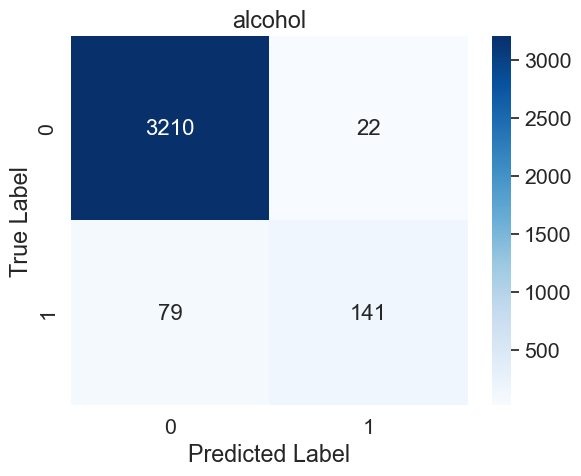

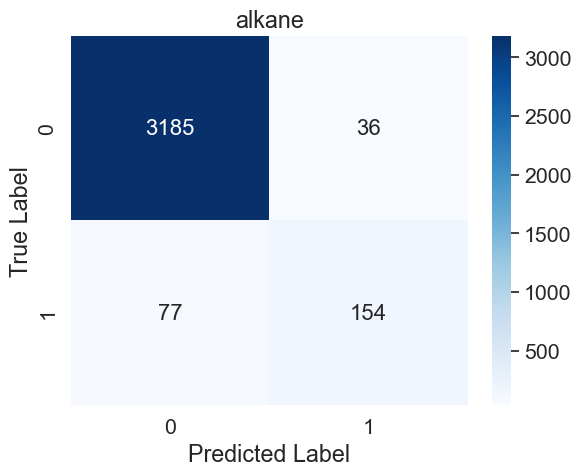

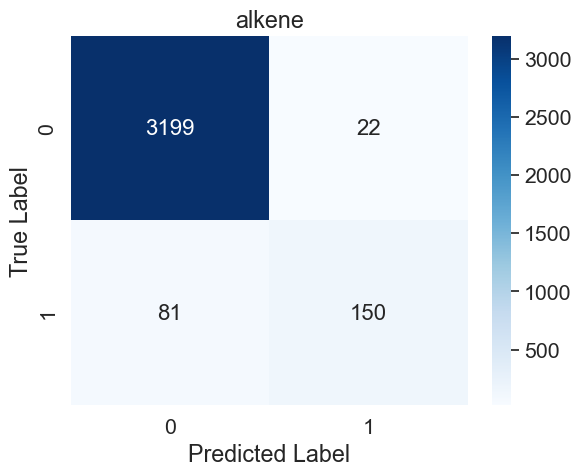

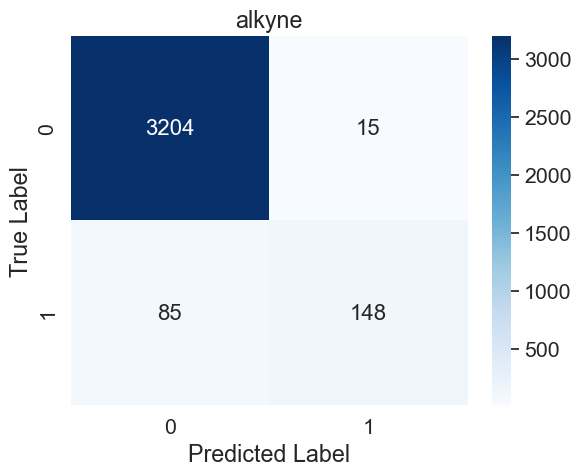

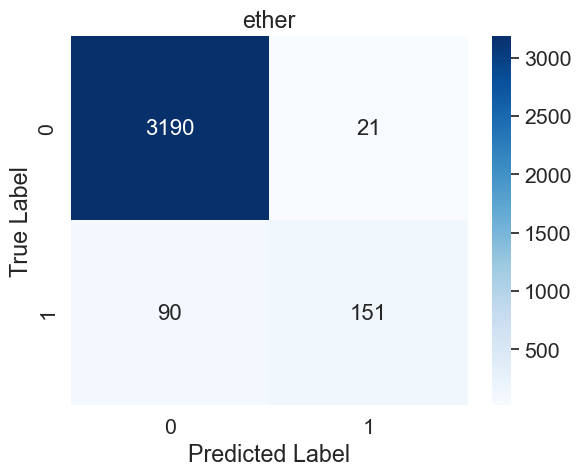

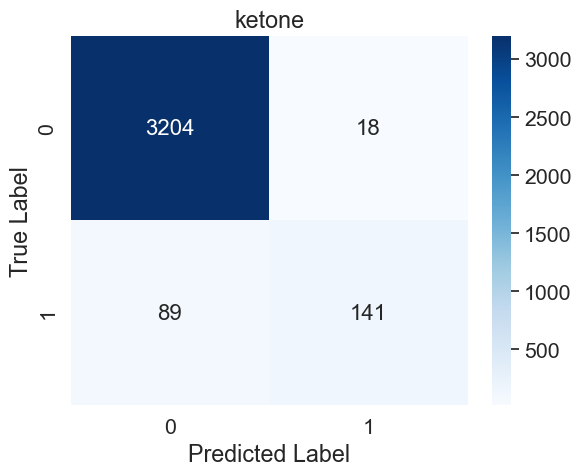

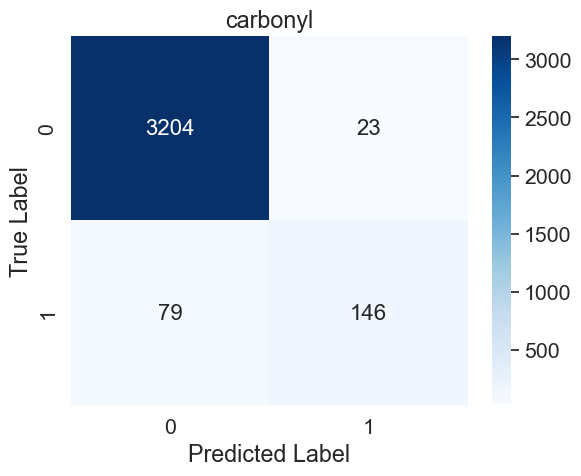

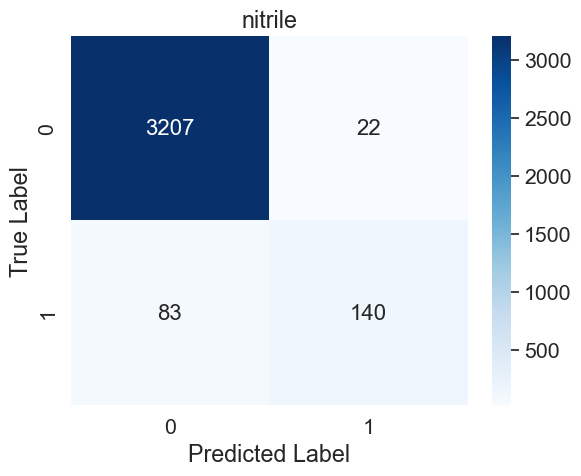

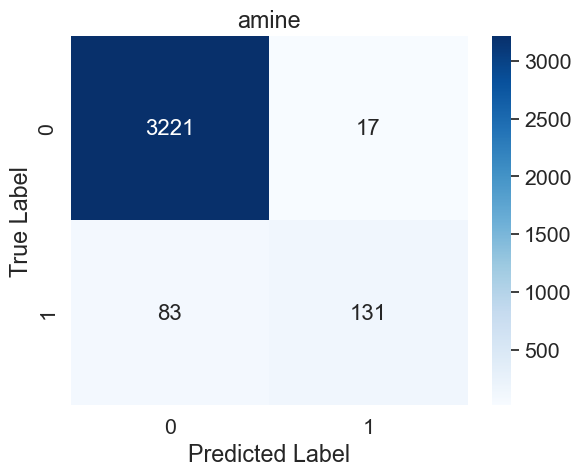

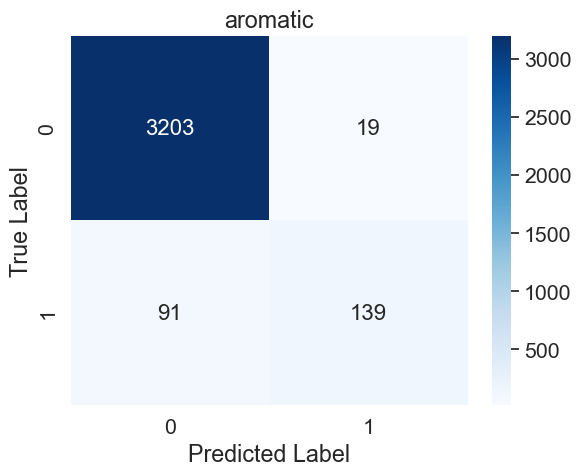

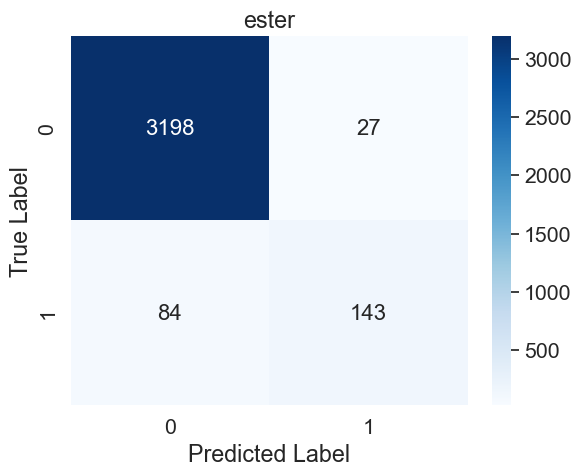

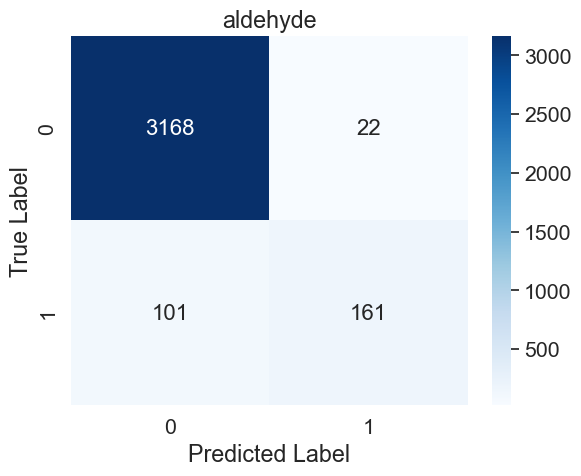

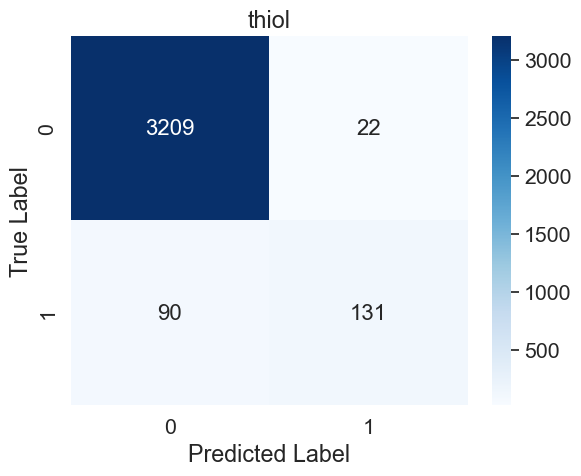

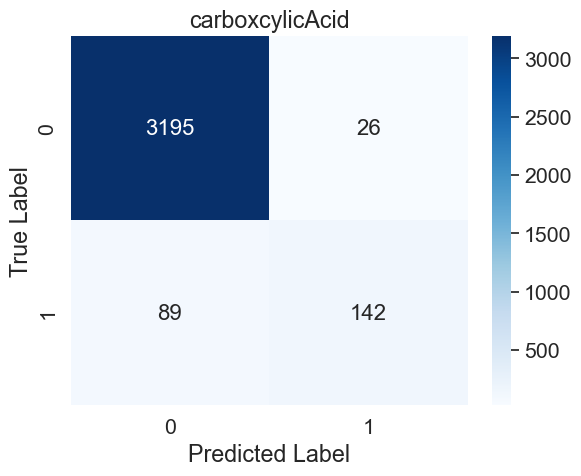

In [107]:
for key in k:
    # Create a heatmap plot of the confusion matrix
    sns.set(font_scale=1.4)
    sns.heatmap(cms[key], annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(key)
    plt.show()

### Issue with class imbalance?
from the confusion matrices we can see that while the overall model is great at predicting the majority class it tends to have issues picking the minority class properly often the accuracy in picking the minority class is much lower than the overall model.

## looking at class imbalance
because many of the classes are so unbalanced it may make an issue in training the model
Below we will look at models trained on the full minority class and a random subset of the majority class

In [116]:
#validating method of creating proper samples with the Thiol functional group
dfThiols = df2[df2.thiol == 0].sample(len(df2[df2.thiol ==1]))
dfThiols = pd.concat([dfThiols, df2[df2.thiol == 1]], ignore_index=True)
dfThiols = dfThiols.sample(frac=1,random_state=42).reset_index(drop=True)#this randomized the dataframe

In [117]:
dfThiols.head(10)

,555.0,558.7440273038,562.4880546075,566.2320819113,569.976109215,573.7201365188,577.4641638225,581.2081911263,584.95221843,588.6962457338,...,alkyne,ether,ketone,carbonyl,nitrile,amine,aromatic,ester,aldehyde,thiol
0,0.020358,0.017402,0.012712,0.010436,0.007720,0.004912,0.003749,0.003441,0.003475,0.003366,...,0,0,0,0,0,0,0,0,0,0
1,0.044472,0.057290,0.047706,0.042967,0.053666,0.025574,0.018391,0.018820,0.024732,0.057789,...,0,1,1,1,0,0,1,0,0,0
2,0.022615,0.036230,0.023785,0.028663,0.021945,0.031461,0.030202,0.023600,0.024683,0.020606,...,0,1,0,0,1,0,1,0,0,0
3,0.028858,0.030066,0.032545,0.034447,0.028733,0.034571,0.033829,0.032980,0.031986,0.022839,...,0,1,1,1,0,0,0,1,0,0
4,0.017183,0.024931,0.013965,0.015156,0.012138,0.013478,0.013232,0.015401,0.015300,0.015725,...,0,1,1,1,0,0,1,1,0,0
5,0.150410,0.111433,0.092399,0.096688,0.118569,0.107414,0.097976,0.073027,0.037321,0.029855,...,0,0,0,0,0,0,1,0,0,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,1,0,1,0,0,0,1
7,0.044572,0.038692,0.038692,0.040297,0.035716,0.031224,0.026620,0.026920,0.028810,0.030923,...,0,0,1,1,0,0,1,0,0,1
8,0.078916,0.073844,0.085926,0.095877,0.110624,0.133648,0.115414,0.099739,0.077638,0.062133,...,0,1,0,0,0,0,1,0,0,1
9,0.284708,0.249141,0.215808,0.188686,0.164693,0.144334,0.129615,0.118811,0.114465,0.112923,...,0,0,0,0,0,0,0,0,0,1


Accuracy: 0.6951219512195121


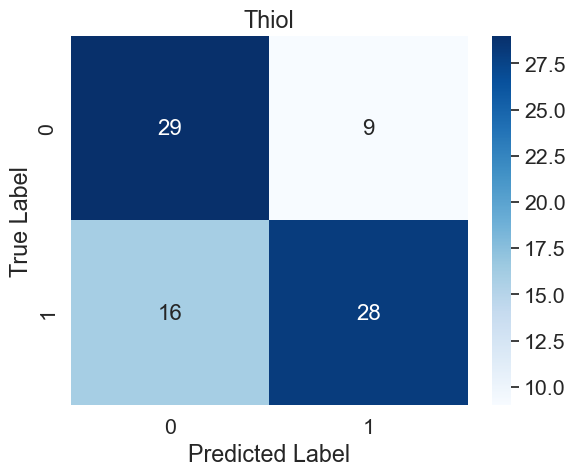

In [119]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(dfThiols.drop(columns=drops), dfThiols['thiol'], test_size=0.2, random_state=42)
# Build the classification model
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)
#make prediction
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Obtain the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap plot of the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Thiol')
plt.show()


## complete the balanced model for every functional group

In [171]:
balancedFrames = {}
for key in k:
    #make the balanced minority and majority class frame
    #we use try and except to catch the two cases first it tries assuming the majority class is 0 
    #then it tries assuming the majority class is 1 if the other threw an exception due to trying to take too large of a sample
    try:
        dfb = df2[df2[key] == 0].sample(len(df2[df2[key] ==1]))
        dfb = pd.concat([dfb,df2[df2[key] ==1]],ignore_index=True)
    except:
        dfb = df2[df2[key] == 1].sample(len(df2[df2[key] ==0]))
        dfb = pd.concat([dfb,df2[df2[key] == 0]],ignore_index=True)
    dfb = dfb.sample(frac=1,random_state=42).reset_index(drop=True) #randomize the dataframe order
    #add the balanced frame to the dictionary
    balancedFrames[key]=dfb


In [172]:
#make a classifier for each functional group out of the balanced dataframes

#ditionaries to hold the models, and important information
balanced_models = {}
balanced_cms = {}
balanced_ypred = {}
balanced_ytest = {}
balanced_accuracy = {}
for key in k:
    #split the data
    X_train, X_test, y_train, y_test = train_test_split(balancedFrames[key].drop(columns=drops), balancedFrames[key][key], test_size=0.2, random_state=42)
    # Build the classification model
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)
    #make prediction
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Obtain the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    #store data
    balanced_models[key]=classifier
    balanced_cms[key]=cm
    balanced_ypred[key] = y_pred
    balanced_ytest[key] = y_test
    balanced_accuracy[key] = accuracy


In [173]:
#check the accuracy of this model
for key in k:
    print('accuracy for ',key,': ',balanced_accuracy[key])

accuracy for  alcohol :  0.8563106796116505
accuracy for  alkane :  0.7250554323725056
accuracy for  alkene :  0.7363796133567663
accuracy for  alkyne :  0.9468085106382979
accuracy for  ether :  0.8465073529411765
accuracy for  ketone :  0.9215456674473068
accuracy for  carbonyl :  0.8890290037831021
accuracy for  nitrile :  0.7267441860465116
accuracy for  amine :  0.8185483870967742
accuracy for  aromatic :  0.8519454269833249
accuracy for  ester :  0.8781818181818182
accuracy for  aldehyde :  0.8351648351648352
accuracy for  thiol :  0.5609756097560976
accuracy for  carboxcylicAcid :  0.9090909090909091


***Wow!*** our accuracy has dropped quite a bit but lets not look and see if the confusion matrix shows an improvement in no longer just simply choosing the majority class

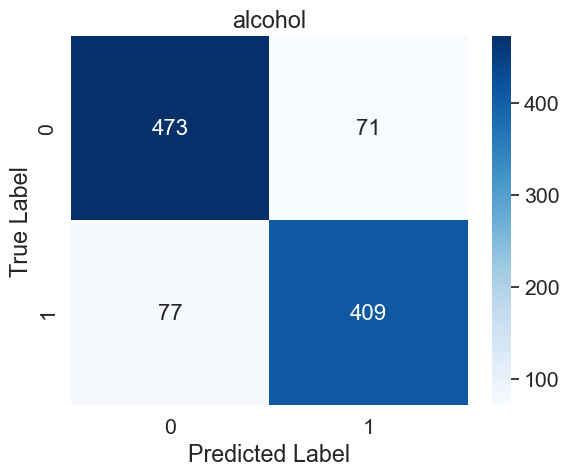

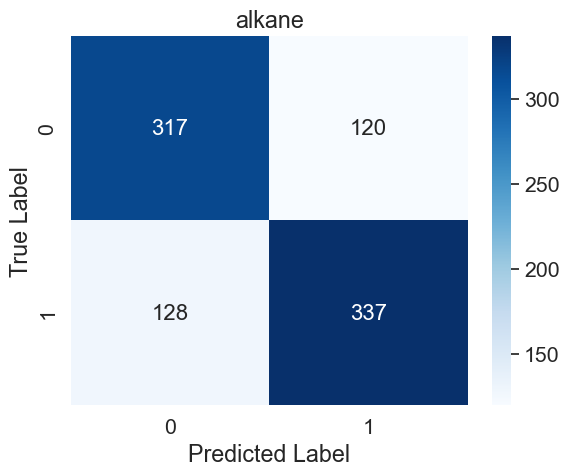

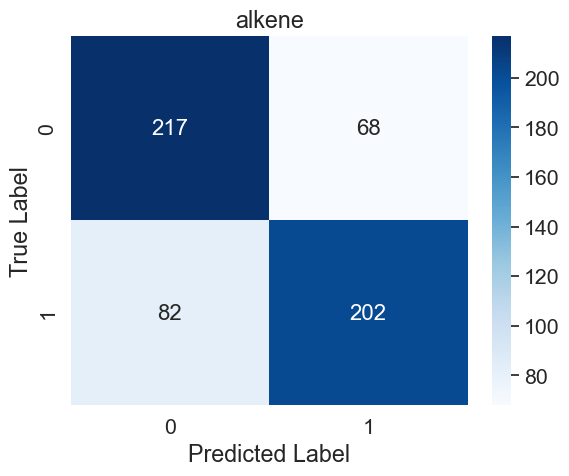

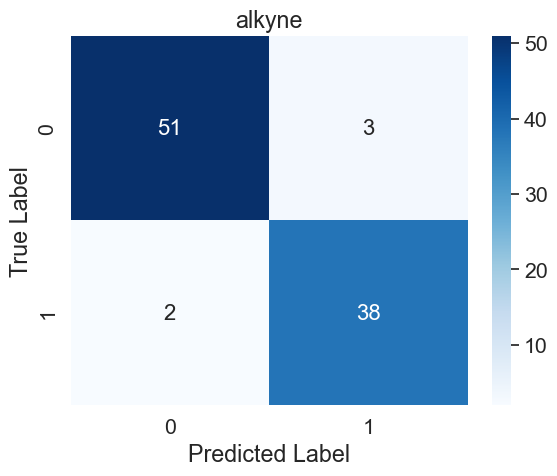

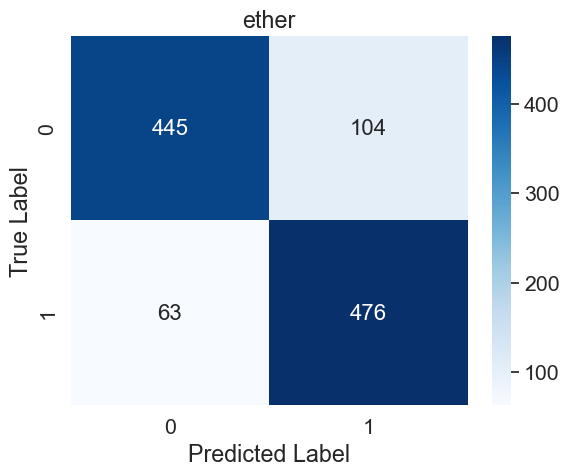

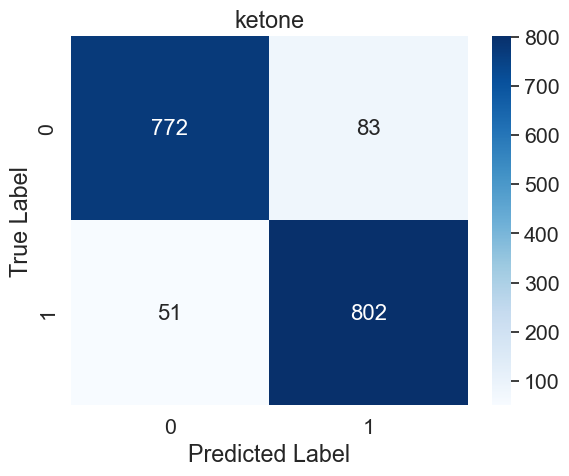

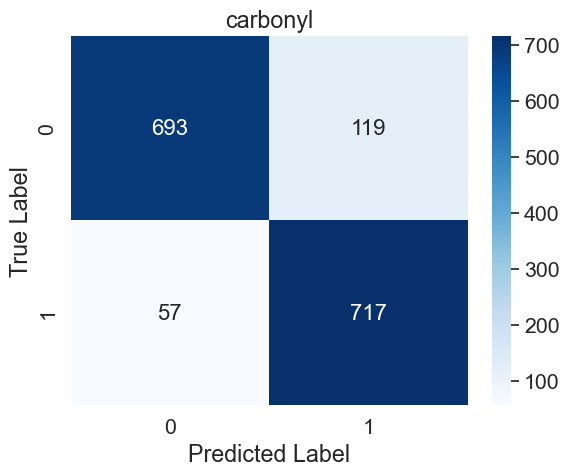

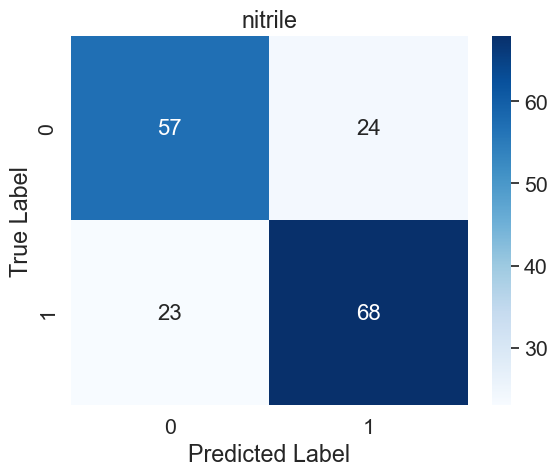

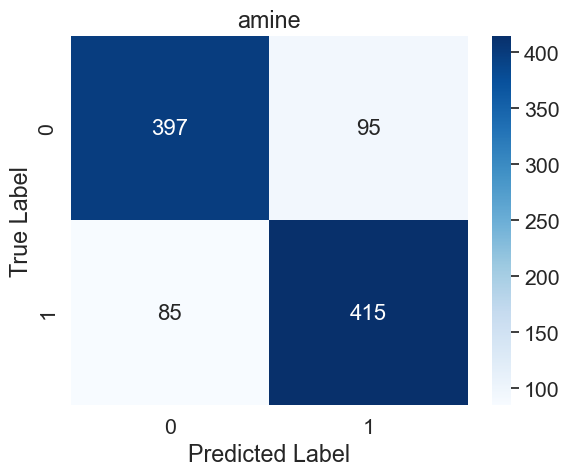

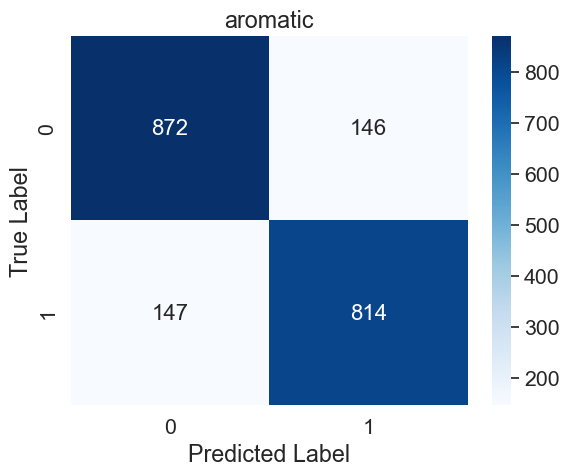

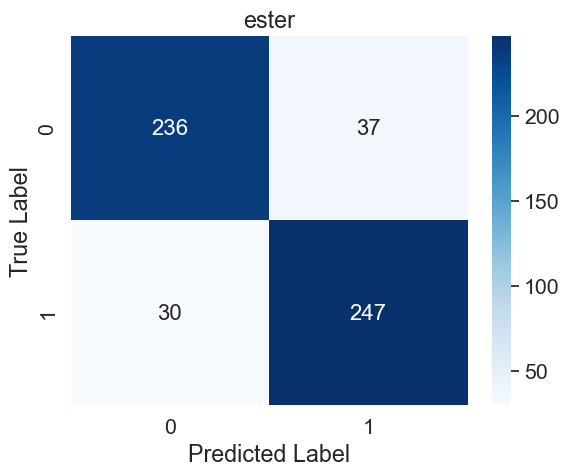

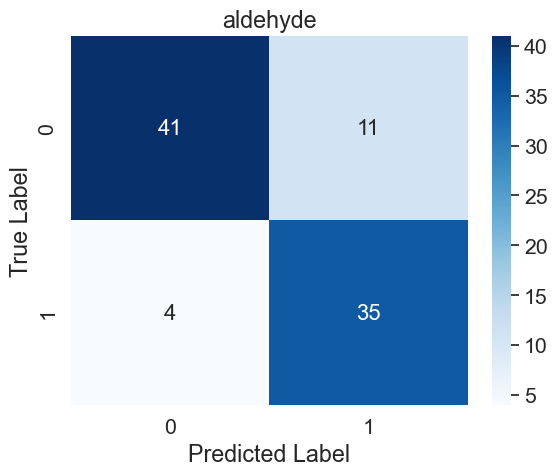

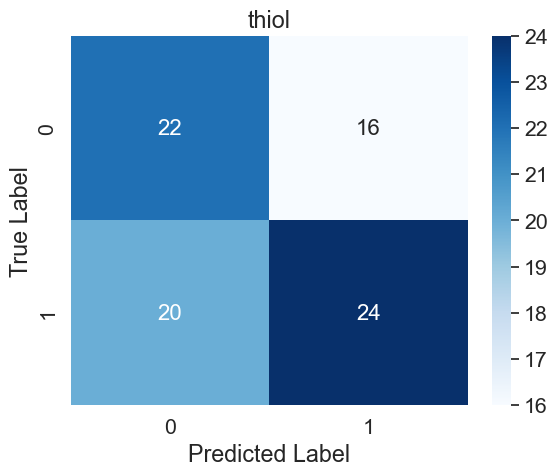

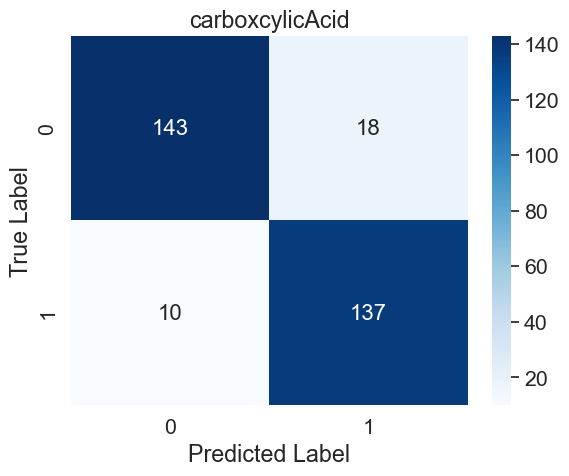

In [174]:
for key in k:
    # Create a heatmap plot of the confusion matrix
    sns.set(font_scale=1.4)
    sns.heatmap(balanced_cms[key], annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(key)
    plt.show()

### discussion of the balanced sets results
Here we see a marked improvement in predicting the minority class correctly even tho overall accuracy went down. 
Take aldehydes for an example:
overall accuracy went from 96% accuracy to 85% accuracy
however when there was an aldehyde present it went from accurately predicting this 61% of the time to 85% of the time
## Now lets look at some model coeficients

In [175]:
#aldehyde coefs.
coefs = balanced_models['aldehyde'].coef_

In [176]:
#find where the coefficient is highest
maxloc = np.where(coefs==coefs.max())[1][0]
maxloc

70

In [177]:
#find the feature name (wavenumber) of the highest coeficient value
df2.iloc[:, maxloc].name


817.0819112628

this is consistent with literature, an aldehyde should see a significant stretch around 2720 wavenumber!
### Now look at all of the functional groups

In [183]:
coefs_dict = {} #hold all of the coefs
#get the coeficients
for key in k:
    coefs_dict[key] = balanced_models[key].coef_
maxlocs = {} #holds the index of the max location for each key
#get the indexes
for key in k:
    maxlocs[key]=np.where(coefs_dict[key]==coefs_dict[key].max())[1][0]

In [184]:
#print the wavenumber of the max coeficent for each functional group
for key in k:
    print('Highest Weighted wavenumber for ',key,' :',df2.iloc[:,maxlocs[key]].name)

Highest Weighted wavenumber for  alcohol  : 3658.7986348123
Highest Weighted wavenumber for  alkane  : 2224.8361774744
Highest Weighted wavenumber for  alkene  : 3089.7064846416
Highest Weighted wavenumber for  alkyne  : 674.8088737201
Highest Weighted wavenumber for  ether  : 2861.3208191126
Highest Weighted wavenumber for  ketone  : 1071.6757679181
Highest Weighted wavenumber for  carbonyl  : 626.1365187713
Highest Weighted wavenumber for  nitrile  : 2236.0682593857
Highest Weighted wavenumber for  amine  : 1520.9590443686
Highest Weighted wavenumber for  aromatic  : 3067.2423208191
Highest Weighted wavenumber for  ester  : 626.1365187713
Highest Weighted wavenumber for  aldehyde  : 817.0819112628
Highest Weighted wavenumber for  thiol  : 1580.8634812287
Highest Weighted wavenumber for  carboxcylicAcid  : 3576.4300341297


***lets compare these to some expected values***<br>
info from libretexts spectroscopy tables<br>
***alcohol*** expected sharp peak around 3700-3584 wavenumbers ***matches model***<br>
***alkanes*** expected most important peaks in the 1500 and 3000 range ***doesn't match model***<br>
***akenes*** expected peak from c=c bending in the 900 range ***matches model***<br>
***alkynes*** expected peak in 3300 range from c-h stretch ***matches model***<br>
***ether*** expected peak in the 12-1500 range for c-o stretch ***doesn't match model***<br>
***ketone*** expected peak 16-1700 ***matches model***<br>
***carbonyl*** expected peak 16-1700 range ***matches model***<br>
***nitrile*** expected peak 2200 range ***matches model***<br>
***amine*** expected peak 35-3300 wavenumber ***doesn't match model***<br>
***aromatic***expected max peak 2000-1650 wavenumber ***doesn't match model***<br>
***ester*** expected peaks 1750 ***does not match model***<br>
***aldehyde*** expected peak 2700 ***matches model***<br>
***thiol*** expected peak around 2600 ***matches model***<br>
***carboxcylic acids*** expected peak 3300-2500 wavenumbers ***matches model***

many of the functional groups have the highest weighted coeficient at the expected functional group but several do not, however many of these still had great predictive power, the ester and aromatic models both correctly predicted the precense of the functional group correctly over 85% of the time. However it did struggle with predicting the alkanes correctly only having an accuracy score of 71%


